# MHC Binding Prediction

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd

import sys, os, math, re

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import xgboost as xgb

import time
from IPython.display import display

%matplotlib inline

In [2]:
# sliding window
def sliding_df (seq_len, sliding_window, dataset):
    seq_len = 9
    sliding_window = 3
    columns = []
    for i in range(seq_len-sliding_window+1):
        columns.append('ss' + str(i))
        dataset['ss' + str(i)] = dataset['sequence'].str[i:i+sliding_window-1]

    def encoder(df):
        for col in columns:
            label_encoder = LabelEncoder()
            label_encoder.fit(df[col])
            df[col] = label_encoder.transform(df[col])
        return df

    y = dataset['class']
    X = dataset.drop(['sequence', 'class'], axis=1)
    X = encoder(X)
    return X, y

       sequence  class
0     AIIDYIAYM      1
1     AIYDTMQYV      1
2     ALATFTVNI      1
3     ALDEGLLPV      1
4     ALFPIIWAL      1
...         ...    ...
9046  KEGAFFLYD      0
9047  KTLCDMIKG      0
9048  RRTRREAIV      0
9049  MMVIFRLMR      0
9050  GKRSNTTGK      0

[9051 rows x 2 columns]


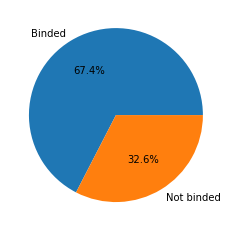

In [3]:
# sequence label
features = []
classes = []

with open(os.path.join('dataset', 'Positive_A0201_9AA_binder_pep.txt'), 'r', encoding='utf-8') as pep_input:
    for line in pep_input:
        if re.match(line, '^#'):
            continue 
        seq=str(line.strip()).upper()
        features.append(seq)
        classes.append(1)

with open(os.path.join('dataset', 'Negative_A0201_9AA_nonbinder_pep.txt'), 'r', encoding='utf-8') as pep_input:
    for line in pep_input:
        if re.match(line, '^#'):
            continue 
        seq=str(line.strip()).upper()
        features.append(seq)
        classes.append(0)

dataset = pd.DataFrame(
    {
        'sequence': features,
        'class': classes
    }
)

print(dataset)

labels = ["Binded",'Not binded']
values = dataset['class'].value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels,  autopct='%1.1f%%')
plt.show()

      sequence  class
0    STAFDFLAV      1
1    SQSPSSFSM      1
2    FALGNVISA      1
3    KINLSLFAL      1
4    LLDSLPMDV      1
..         ...    ...
295  YLYDRLLRI      0
296  YLSKIIPAL      0
297  TPTVPSGSF      0
298  VVLSWAPPV      0
299  ARDIYRASY      0

[300 rows x 2 columns]


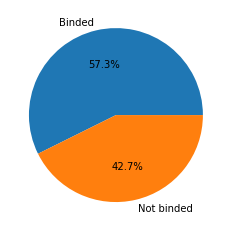

In [4]:
# sequence label
features = []
classes = []

with open(os.path.join('dataset', 'dbPepNeo_HC_neoantigens_positive.txt'), 'r', encoding='utf-8') as pep_input:
    for line in pep_input:
        if re.match(line, '^#'):
            continue 
        line = line.strip()
        if line.isalpha():
            seq=str(line).upper()
            features.append(seq)
            classes.append(1)

with open(os.path.join('dataset', 'dbPepNeo_HC_neoantigens_negative.txt'), 'r', encoding='utf-8') as pep_input:
    for line in pep_input:
        if re.match(line, '^#'):
            continue 
        line = line.strip()
        if line.isalpha():
            seq=str(line).upper()
            features.append(seq)
            classes.append(0)

dataset_cancer = pd.DataFrame(
    {
        'sequence': features,
        'class': classes
    }
)

print(dataset_cancer)

labels = ["Binded",'Not binded']
values = dataset_cancer['class'].value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels,  autopct='%1.1f%%')
plt.show()

In [5]:
X, y = sliding_df (seq_len = 9, sliding_window = 3, dataset = dataset)
print(X)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

X2, y2 = sliding_df (seq_len = 9, sliding_window = 3, dataset = dataset_cancer)

TypeError: 'type' object is not subscriptable

In [5]:
decision_tree = DecisionTreeClassifier(random_state=3)

decision_tree.fit(X_train, y_train)

prediction_tree = decision_tree.predict(X_test)

print("========= dataset 1 ================")

print("Test result (accuracy):", decision_tree.score(X_test, y_test))

auc_roc_tree = roc_auc_score(y_test, prediction_tree)

print("AUC-ROC:", auc_roc_tree)

print("F-measure: ", f1_score(y_test, prediction_tree > 0.48))

print("====================================")

print("========= dataset 2 ================")

prediction_tree2 = decision_tree.predict(X2)

print("Test result (accuracy):", decision_tree.score(X2, y2))

auc_roc_tree2 = roc_auc_score(y2, prediction_tree2)

print("AUC-ROC:", auc_roc_tree2)

print("F-measure: ", f1_score(y2, prediction_tree2 > 0.48))

========= dataset 1 ================
Test result (accuracy): 0.7673048600883653
AUC-ROC: 0.7380962519323515
F-measure:  0.646927374301676
========= dataset 2 ================
Test result (accuracy): 0.4533333333333333
AUC-ROC: 0.5192587209302325
F-measure:  0.1276595744680851


In [5]:
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=3), n_estimators=100)

bagging.fit(X_train, y_train)

prediction_bagging = bagging.predict(X_test)

auc_roc_tree = roc_auc_score(y_test, prediction_bagging)

print("AUC-ROC:", auc_roc_tree)

print("F-measure: ", f1_score(y_test, prediction_bagging > 0.48))

AUC-ROC: 0.7984263484805005
F-measure:  0.7293577981651376


[21:41:47] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.86716
[1]	train-auc:0.87315
[2]	train-auc:0.87451
[3]	train-auc:0.87671
[4]	train-auc:0.88014
[5]	train-auc:0.88265
[6]	train-auc:0.88580
[7]	train-auc:0.88873
[8]	train-auc:0.88889
[9]	train-auc:0.89061
[10]	train-auc:0.89348
[11]	train-auc:0.89504
[12]	train-auc:0.89601
[13]	train-auc:0.89895
[14]	train-auc:0.90060
[15]	train-auc:0.90187
[16]	train-auc:0.90302
[17]	train-auc:0.90655
[18]	train-auc:0.90870
[19]	train-auc:0.91073
[20]	train-auc:0.91309
[21]	train-auc:0.91574
[22]	train-auc:0.91744
[23]	train-auc:0.91802
[24]	train-auc:0.92063
[25]	train-auc:0.92301
[26]	train-auc:0.92508
[27]	train-auc:0.92745
[28]	train-auc:0.92922
[29]	train-auc:0.

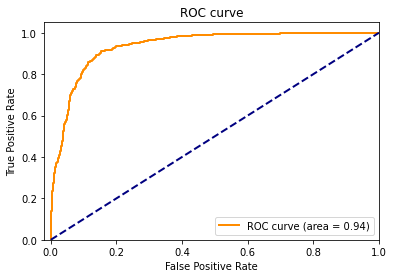

AUC-ROC: 0.5186909520348837


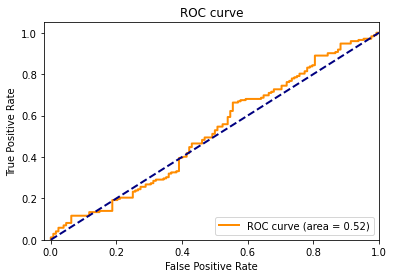

In [6]:

params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": 0.1,
    "min_child_weight": 1,
    "max_depth": 6,
    "nthread": 4,
    "silent": 1,
}

xgb_train = xgb.DMatrix(X_train.values, y_train.values)
xgb_test = xgb.DMatrix(X_test.values)

num_round = 300
watchlist = [(xgb_train, 'train')]
model = xgb.train(params, xgb_train, num_round, watchlist)

y_pred = model.predict(xgb_test)

auc_roc = roc_auc_score(y_test, y_pred)

print("AUC-ROC:", auc_roc)

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

xgb_test2 = xgb.DMatrix(X2.values)

y_pred2 = model.predict(xgb_test2)

auc_roc2 = roc_auc_score(y2, y_pred2)

print("AUC-ROC:", auc_roc2)

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y2, y_pred2)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

[21:46:15] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.84472
[1]	train-auc:0.85095
[2]	train-auc:0.85187
[3]	train-auc:0.85359
[4]	train-auc:0.85507
[5]	train-auc:0.85770
[6]	train-auc:0.85945
[7]	train-auc:0.86236
[8]	train-auc:0.86421
[9]	train-auc:0.86640
[10]	train-auc:0.86855
[11]	train-auc:0.87100
[12]	train-auc:0.87337
[13]	train-auc:0.87589
[14]	train-auc:0.87733
[15]	train-auc:0.87901
[16]	train-auc:0.88082
[17]	train-auc:0.88216
[18]	train-auc:0.88617
[19]	train-auc:0.88914
[20]	train-auc:0.89135
[21]	train-auc:0.89397
[22]	train-auc:0.89565
[23]	train-auc:0.89850
[24]	train-auc:0.90054
[25]	train-auc:0.90314
[26]	train-auc:0.90509
[27]	train-auc:0.90666
[28]	train-auc:0.90904
[29]	train-auc:0.

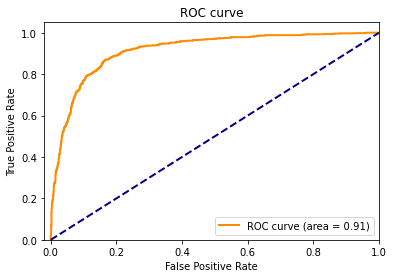

In [7]:
X = X.append(X2)
y = y.append(y2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

xgb_train = xgb.DMatrix(X_train.values, y_train.values)
xgb_test = xgb.DMatrix(X_test.values)

num_round = 300
watchlist = [(xgb_train, 'train')]
model = xgb.train(params, xgb_train, num_round, watchlist)

y_pred = model.predict(xgb_test)

auc_roc = roc_auc_score(y_test, y_pred)

print("AUC-ROC:", auc_roc)

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# conda install -c conda-forge biopython
from Bio.SeqUtils.ProtParam import ProteinAnalysis
analyzed_seq = ProteinAnalysis(str(seq))
analyzed_seq.molecular_weight()
analyzed_seq.count_amino_acids()